In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import filters

Get image response

In [3]:
def compute_harris_response(img, sigma=3):
    """
    Compute the Harris corner detector response function
    for each pixel in a graylevel image.
    """
    # derivatives
    Ix = filters.gaussian_filter(img, sigma=(sigma,sigma), order=(0,1))
    Iy = filters.gaussian_filter(img, sigma=(sigma,sigma), order=(1,0))
    # compute components of the Harris matrix
    Wxx = filters.gaussian_filter(Ix**2, sigma=sigma)
    Wxy = filters.gaussian_filter(Ix*Iy, sigma=sigma)
    Wyy = filters.gaussian_filter(Iy**2, sigma=sigma)
    # determinant and trace
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy + 1e-6
    return Wdet/Wtr

Get harris points

In [4]:
def get_harris_points(img_response, min_dist=10, threshold=0.1):
    """
    Return corners from a Harris response image
    min_dist is the minimum number of pixels separating
    corners and image boundary.
    """
    # find top corner candidates above a threshold
    threshold = img_response.max() * threshold
    img_response_t = (img_response > threshold).astype(int)
    # get coordinates of candidates and their values
    coords = np.array(img_response_t.nonzero()).T
    values = [img_response[i, j] for i,j in coords]
    # sort candidates
    index = np.argsort(values)
    # store allowed point locations in array
    allowed_locations = np.zeros(img_response.shape)
    allowed_locations[min_dist: -min_dist, min_dist: -min_dist] = 1
    # select the best points taking min_distance into account
    filtered_coords = []
    for idx in index:
        i, j = coords[idx]
        if allowed_locations[i, j] == 1:
            filtered_coords.append((i, j))
            allowed_locations[(i - min_dist): (i + min_dist),
                              (j - min_dist): (j + min_dist)] = 0
    return filtered_coords

In [5]:
def plot_harris_points(image, filtered_coords):
    """ Plots corners found in image. """
    plt.figure()
    plt.gray()
    plt.imshow(image)
    plt.plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords],'*')
    plt.axis('off')
    plt.show()

In [6]:
img = np.array(Image.open('images/empire.jpg').convert('L'))

img_response = compute_harris_response(img, sigma=1.5)

In [7]:
filtered_coords = get_harris_points(img_response, min_dist=6, threshold=0.05)

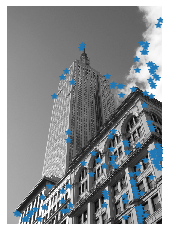

In [8]:
plot_harris_points(img, filtered_coords)

In [9]:
def get_descriptors(image, filtered_coords, window_size=5):
    """
    For each point return, pixel values around the point
    using a neighbourhood of width 2*wid+1. (Assume points are
    extracted with min_distance > wid).
    """
    descriptors = []
    for (i, j) in filtered_coords:
        patch = image[i - window_size: i + window_size + 1,
                      j - window_size: j + window_size + 1].flatten()
        descriptors.append(patch)
    return descriptors

In [21]:
def match(descriptorsA, descriptorsB, threshold=0.5):
    """
    For each corner point descriptor in the first image,
    select its match to second image using
    normalized cross-correlation.
    """
    n = len(descriptorsA[0])
    # pair-wise distances
    dist = - np.ones((len(descriptorsA), len(descriptorsB)))
    for i in range(len(descriptorsA)):
        for j in range(len(descriptorsB)):
            da = descriptorsA[i]
            db = descriptorsB[j]
            d1 = (da - np.mean(da))/np.std(da)
            d2 = (db - np.mean(db))/np.std(db)
            ncc_value = np.sum(d1 * d2)/(n-1)
            if ncc_value > threshold:
                dist[i, j] = ncc_value
    idx = np.argsort(-dist)
    matchscores = idx[:, 0]
    return matchscores

In [22]:
def bimatch(descriptorsA, descriptorsB, threshold=0.5):
    """
    Two-sided symmetric version of match().
    """
    matches_12 = match(descriptorsA, descriptorsB,threshold)
    matches_21 = match(descriptorsB, descriptorsA,threshold)
    ndx_12 = np.where(matches_12 >= 0)[0]
    # remove matches that are not symmetric
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1
    return matches_12

In [23]:
def concat_images(imgA, imgB):
    """
    Return a new image that appends the two images side-by-side.
    """
    # select the image with the fewest rows and fill in enough empty rows
    rowsA = len(imgA)
    rowsB = len(imgB)
    if rowsA < rowsB:
        empty = np.zeros((rowsB - rowsA, imgA.shape[1]))
        imgA = np.concatenate((imgA, empty),axis=0)
    elif rowsA > rowsB:
        empty = np.zeros((rowsA - rowsB, imgB.shape[1]))
        imgB = np.concatenate((imgB, empty),axis=0)
    # if none of these cases they are equal, no filling needed.
    return np.concatenate((imgA, imgB), axis=1)

In [27]:
def plot_matches(imgA, imgB, locsA, locsB, matchscores, show_below=True):
    """
    Show a figure with lines joining the accepted matches
    input: im1,im2 (images as arrays), locs1,locs2 (feature locations),
    matchscores (as output from 'match()'),
    show_below (if images should be shown below matches).
    """
    imgC = concat_images(imgA, imgB)
    if show_below:
        imgC = np.vstack((imgC, imgC))

    plt.imshow(imgC)
    colsA = imgA.shape[1]
    for i,m in enumerate(matchscores):
        if m>0:
            plt.plot([locsA[i][1], locsB[m][1]+colsA],
                     [locsA[i][0], locsB[m][0]],'c')
    plt.axis('off')

In [33]:
imgA = np.array(Image.open('images/alcatraz1.jpg').convert('L'))

imgA_response = compute_harris_response(imgA, sigma=5)
filtered_coordsA = get_harris_points(imgA_response, min_dist=6)
descriptorsA = get_descriptors(imgA, filtered_coordsA, window_size=5)

imgB = np.array(Image.open('images/alcatraz2.jpg').convert('L'))

imgB_response = compute_harris_response(imgB, sigma=5)
filtered_coordsB = get_harris_points(imgB_response, min_dist=6)
descriptorsB = get_descriptors(imgB, filtered_coordsB, window_size=5)

scores = match(descriptorsA, descriptorsB)[:10]

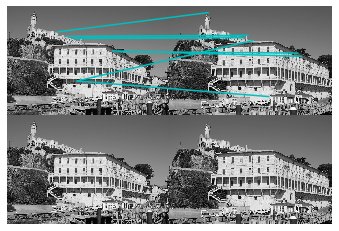

In [34]:
plot_matches(imgA, imgB, filtered_coordsA, filtered_coordsB, scores, show_below=True)